In [114]:
import os
import cv2
import collections
import json
import matplotlib.pyplot as plt
import spacy
import pickle
import numpy as np
import random
nlp = spacy.load("en_core_web_sm")

In [82]:
# frame_id: S01_c001_000001
root = '/data/datasets/aicity2022/track2'
det_dict = collections.defaultdict(list)
for sub_dir in ['train/S01', 'validation/S02', 'train/S03', 'train/S04', 'validation/S05']:
    sid = sub_dir.split('/')[-1]
    for cid in os.listdir(os.path.join(root, sub_dir)):
        train_path = os.path.join(os.path.join(root, sub_dir), cid)
        # det_path = os.path.join(train_path, 'det/det_mask_rcnn.txt')
        det_path = os.path.join(train_path, 'det/det_yolo3.txt')
        # det_path = os.path.join(train_path, 'det/det_ssd512.txt')

        det_results = []

        with open(det_path, 'r') as fb:

            for line in fb.readlines():
                frame, ID, left, top, width, height, _, _, _, _ = line.split(',')
                frame_id = '%s_%s_%s' % (sid, cid, int(frame))

                ID = int(ID)
                left, top, width, height = map(lambda x: int(float(x)), (left, top, width, height))

                det_results.append([frame, ID, left, top, width, height])
                det_dict[frame_id].append([left, top, width, height])


In [ ]:
with open('/data/AIC21-R1/data/test_tracks.json', 'r') as fb:
    test_tracks = json.load(fb)
    
with open('/data/AIC21-R1/data/test_queries.json', 'r') as fb:
    test_queries = json.load(fb)
    
print('length of test_tracks: %d' % len(test_tracks))
print('length of test_queries: %d' % len(test_queries))

In [117]:
def compute_iou(rec1, rec2):
    """
    computing IoU
    :param rec1: (y0, x0, y1, x1), which reflects
            (top, left, bottom, right)
    :param rec2: (y0, x0, y1, x1)
    :return: scala value of IoU
    """
    # computing area of each rectangles
    S_rec1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
    S_rec2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])

    # computing the sum_area
    sum_area = S_rec1 + S_rec2

    # find the each edge of intersect rectangle
    left_line = max(rec1[1], rec2[1])
    right_line = min(rec1[3], rec2[3])
    top_line = max(rec1[0], rec2[0])
    bottom_line = min(rec1[2], rec2[2])

    # judge if there is an intersect
    if left_line >= right_line or top_line >= bottom_line:
        return 0
    else:
        intersect = (right_line - left_line) * (bottom_line - top_line)
        return (intersect / (sum_area - intersect)) * 1.0

'''
test_track_bboxes:
{
    "track_id": {
        "frame_1": [gt_box, ...],
        "frame_2": [gt_box, ...],
        ...
    }
}
First box of each track_id is the gt_box of this track
'''
test_track_bboxes = dict()
num_samples = 3
for track_id, track in test_tracks.items():
    test_track_bboxes[track_id] = dict()
    ids = random.choices(track['frames'], k=num_samples)
#     print(ids)
    
    for idx in ids:
        test_track_bboxes[track_id][idx] = []
        frame = idx
        # left, top, width, height
        for box, frame_name in zip(track['boxes'], track['frames']):
            if frame_name == frame:
                gt_box = box
                break
#         gt_box = track['boxes'][idx]
        cid = frame.split('/')[-3]
        sid = frame.split('/')[-4]
        frame_num = int(frame.split('/')[-1].split('.')[-2])
        frame_id = '%s_%s_%s' % (sid, cid, frame_num)
        all_boxes = det_dict[frame_id]
        
        # left, top, width, height
#         image = cv2.imread(os.path.join('/data/datasets/aicity2022/track2', frame))
#         cv2.rectangle(image, (gt_box[0], gt_box[1]), (gt_box[0]+gt_box[2], gt_box[1]+gt_box[3]), (0, 255, 0), 2)
        max_iou = 0
        max_iou_id = 0
        for iou_id, box in enumerate(all_boxes):
            box1 = (gt_box[0], gt_box[1], gt_box[0]+gt_box[2], gt_box[1]+gt_box[3])
            box2 = (box[0], box[1], box[0]+box[2], box[1]+box[3])
#             cv2.rectangle(image, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), (0, 0, 255), 2)
            iou = compute_iou(box1, box2)
            if iou > max_iou:
                max_iou = iou
                max_iou_id = iou_id
        
        for iou_id, box in enumerate(all_boxes):
            if box[2] * box[3] >= (gt_box[2] * gt_box[3] * 2/3) and iou_id != max_iou_id:
                test_track_bboxes[track_id][idx].append(box)
        
        test_track_bboxes[track_id][idx].insert(0, gt_box)
#         plt.figure(figsize=(15, 15))
#         plt.imshow(image)
#         plt.show()
    
#     break
    

In [118]:
with open('test_track_bboxes.json', 'w') as fb:
    json.dump(test_track_bboxes, fb)

/data/datasets/aicity2022/track2/train/S01/c001/img1/000500.jpg


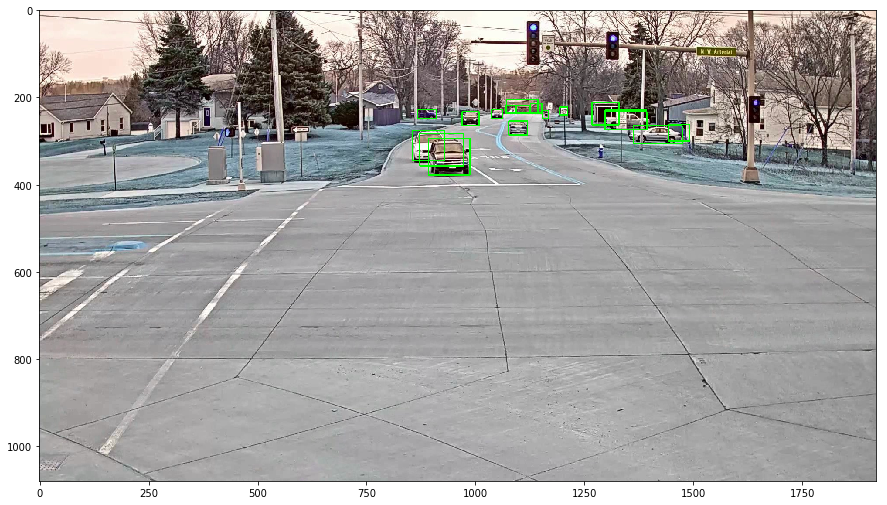

In [69]:
base_image_path = os.path.join(train_path, 'img1')
frame_id = 500
image_path = os.path.join(base_image_path, '%06d.jpg' % frame_id)
print(image_path)
image = cv2.imread(image_path)
plt.figure(figsize=(15, 15))
for bbox in det_dict[frame_id]:
    _, _, left, top, width, height = bbox
    
    cv2.rectangle(image, (left, top), (left+width, top+height), (0, 255, 0), 2)

    plt.imshow(image)

In [25]:
all_cars = set()
for _, query in test_queries.items():
    texts = query["nl"]
    for text in texts:
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            all_cars.add(chunk.root.text.lower())
print(all_cars)

{'chevy', 'spv', 'suv', 'white', 'van', 'car', 'stops', 'tuns', 'he', 'pickup', 'sedan', 'cross', 'it', 'focus', 'bus', 'switches', 'hatchback', 'turning', 'wheeler', 'jeep', 'runs', 'intersection', 'driving', 'track', 'pick', 'svu', 'cargo', 'truck', 'turn', 'road', 'size', 'turns', 'mpv', 'minivan', 'grey', 'waits', 'coupe', 'wagon', 'chevrolet', 'street', 'merges', 'vehicle', 'drives', 'midsize'}


In [43]:
all_cars = ['chevy',
        'spv',
        'suv',
        'van',
        'car',
        'tuns',
        'pickup', 
        'sedan',
        'bus', 
        'switches', 
        'hatchback', 
        'wheeler', 
        'jeep', 
        'driving',
        'track', 
        'pick', 
        'svu', 
        'cargo', 
        'truck',
        'mpv',
        'minivan',
        'coupe', 
        'wagon', 
        'chevrolet',
        'vehicle', 
        'drives']

In [52]:
query_car_dict = collections.defaultdict(list)

for query_id, query in test_queries.items():
    texts = query["nl"]
    cars = [[] for _ in range(len(texts))]
    for idx, text in enumerate(texts):
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            for word in str(chunk).split(' '):
                if word.lower() in all_cars:
                    cars[idx].append(str(chunk).lower())
                    break
    cars = sorted(cars, key=lambda x: -len(x))
    query_car_dict[query_id] = cars[0]

In [89]:
query_car_dict
with open('test_query_cars.json', 'w') as fb:
    json.dump(query_car_dict, fb)

In [102]:
with open('/data/AIC21-R1/data/query_lang_embeds.pkl', 'rb') as fb:
    query_lang_embeds = pickle.load(fb)

with open('/data/AIC21-R1/data/track_car_embeds.pkl', 'rb') as fb:
    track_car_embeds = pickle.load(fb)

In [104]:
query = next(iter(query_lang_embeds.items()))[1]
track = next(iter(track_car_embeds.items()))[1]


In [116]:
for q in query:
    for t in track:
        print(np.matmul(q, t.T))

60.12961
-29.092068
24.40782
11.5822525
-2.3705869
-5.9939823
-49.48214
-8.082773
-16.42072
-6.8288994
56.46681
-30.57659
17.925411
0.17423058
-9.4691925
-9.370908
-23.719799
1.9964485
-7.383226
-17.91505
67.06519
-27.114456
11.430223
9.863023
0.302491
-28.749146
-7.4024677
-16.047039
-12.414078
